This notebook represents the baseline of the Lorenz 63 experiment presented in the paper. It solves the online learning problem using the exact gradient computed using automatic differentiation. 

In [51]:
from generate_data import generate_data
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchdiffeq import odeint as odeint_torch
from utils import reshape_dataset_to_torch, train_L63

In [52]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [53]:
# parameters of the training experiment
params = {'grad_mode': 'exact','dim_state': 3, 'dim_output': 3, 'transition_layers': 2, 'dim_hidden_dyn_mdl': 3, 'train_size': 5000,
          'ntrain': 300, 'dt_integration': 0.01, 'pretrained': False, 'Batch_size': 128, 'seq_size': 10,
          'nb_part': 5, 'output_folder': 'output_models/',
          'model_save_file_name': 'L63_exact_gradient.pt', 'device': 'cuda'}

The Lorenz 63 dynamical system is a 3-dimensional model of the form:
\begin{equation}
\begin{aligned}
    \dot{{u}}^{\dagger}_{t,1} &= \sigma({u}^{\dagger}_{t,2}-{u}^{\dagger}_{t,1})\\
    \dot{{u}}^{\dagger}_{t,2} &= \rho {u}^{\dagger}_{t,1} - {u}^{\dagger}_{t,2} - {u}^{\dagger}_{t,1}{u}^{\dagger}_{t,3}\\
    \dot{{u}}^{\dagger}_{t,3} &= {u}^{\dagger}_{t,1}{u}^{\dagger}_{t,2} - \beta{u}^{\dagger}_{t,3}
\end{aligned}
\end{equation}
Under parametrization $\sigma =10$, $\rho=28$ and  $\beta=8/3$, this system exhibits chaotic dynamics with a strange attractor.

We assume here that we are provided with $\mathrm{F}$, an imperfect version of the above Lorenz system that does not include the term $\beta{u}^{\dagger}_{t,3}$. This new model can not simulate the Lorenz 63 strange attractor and converges to an equilibrium point. We correct this physical core with a sub-model $\mathrm{M}_{\mathrm{\theta}}$ as follows:
\begin{equation}
\dot{\mathrm{u}}_t = \underbrace{\mathrm{F}(\mathrm{u}_t) + \mathrm{M}_{\mathrm{\theta}}(\mathrm{u}_t)}_{\text{Hybrid model}}
\end{equation}
where $\mathrm{u}_t = [{u}_{t,1},{u}_{t,2},{u}_{t,3}]^T$ and $\mathrm{F}: \mathbb{R}^3 \longrightarrow \mathbb{R}^3$ is given by:
\begin{equation}
\begin{aligned}
    F_1(\mathrm{u}_t) &= \sigma({u}_{t,2}-{u}_{t,1})\\
    F_2(\mathrm{u}_t) &= \rho {u}_{t,1} - {u}_{t,2} - {u}_{t,1}{u}_{t,3}\\
    F_3(\mathrm{u}_t) &= {u}_{t,1}{u}_{t,2}
\end{aligned}
\end{equation}
The sub-model $\mathrm{M}_{\mathrm{\theta}}$ is a fully connected neural network with parameters $\mathrm{\theta}$. The resulting hybrid system is solved in time using the dopri5 solver, and in this notebook, we present an online calibration experiment where we have access to the gradients of the numerical solver. 

In [54]:
class HybridMdl(torch.nn.Module):
    def __init__(self, params):
        super(HybridMdl, self).__init__()
        # params of the true L63 system
        self.sigma = GD.parameters.sigma
        self.rho = GD.parameters.rho
        self.beta = GD.parameters.beta

        # params of the neural network correction
        self.trans_layers = params['transition_layers']
        self.transLayers = torch.nn.ModuleList([torch.nn.Linear(params['dim_state'], params['dim_hidden_dyn_mdl'])])
        self.transLayers.extend([torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_hidden_dyn_mdl']) for i in
                                 range(1, params['transition_layers'])])
        self.out_transLayers = torch.nn.Linear(params['dim_hidden_dyn_mdl'], params['dim_state'])

    def closure(self, x):
        for i in range(self.trans_layers):
            x = torch.tanh(self.transLayers[i](x))
        x = self.out_transLayers(x)
        return x

    def dyn_net(self, t, inp, closure = True):
        grad = (torch.zeros((inp.size())).to(inp.device))
        grad[:, 0] = self.sigma * (inp[:, 1] - inp[:, 0])
        grad[:, 1] = inp[:, 0] * (self.rho - inp[:, 2]) - inp[:, 1]
        grad[:, 2] = inp[:, 0] * inp[:, 1]  # + self.beta*inp[:,2];
        if closure:
            return grad + self.closure(inp)
        else:
            return grad
    def model_dt(self, inp, dt, t0=0,
                grad_mode='exact'):  # flow of the ODE, assuming the flow is autonomous so t0 is always 0
        if grad_mode == 'exact':
            pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt).to(inp.device), method='dopri5')
            return pred[-1, :, :]
        elif grad_mode == 'EGA-static' or grad_mode == 'EGA-ST' or grad_mode == 'EGA-J':
            with torch.no_grad():
                # blackbox non diff solver, here an adaptive dopri solver
                pred = odeint_torch(self.dyn_net, inp, torch.arange(t0, dt + 0.000001, dt), method='dopri5')
            # computational graph of the blackbox solver
            if grad_mode == 'EGA-static':
                output_p = dt * self.closure(inp.detach()) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-ST':
                output_p = dt * self.closure(inp) + inp
                output_p.data = pred.data[-1, :, :]
            elif grad_mode == 'EGA-J':
                output_p = dt * self.dyn_net(t0+dt,inp) + inp
                output_p.data = pred.data[-1, :, :]                
            return output_p
    def forward(self,dt, n, x0, closure = True, grad_mode = 'exact'):
        pred = [x0]
        for i in range(n):
            pred.append(self.model_dt(pred[-1],dt, grad_mode = grad_mode))
        pred_seq = torch.stack(pred)
        return pred_seq

In [55]:
class GD:
    model = 'Lorenz_63'

    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0 / 3

    dt_integration = params['dt_integration']  # integration time
    nb_loop_data = 60.0

In [56]:
# run the data generation
dataset = generate_data(GD)

In [57]:
# reshaping dataset
X_train, Y_train, X_test, Y_test = reshape_dataset_to_torch(dataset, params['seq_size'], params['train_size'])
training_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
val_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=params['Batch_size'], shuffle=True,
                                         pin_memory=False),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=params['Batch_size'], shuffle=False, pin_memory=False),
}

In [58]:
hybrid_L63 = HybridMdl(params).to(params['device'])

In [59]:
optimizer_ft = torch.optim.Adam(hybrid_L63.parameters(), lr=0.1)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)
model_best_valid, model, loss_train, loss_val = train_L63(hybrid_L63, dataloaders, optimizer_ft, exp_lr_scheduler, device=params['device'], num_epochs=params['ntrain'], dt=params['dt_integration'], seq_size=params['seq_size'], grad_mode=params['grad_mode'])
torch.save(model.state_dict(), params['output_folder'] + params['model_save_file_name'])

Epoch 0/299
----------
train: loss: 0.322779
LR 0.1
val: loss: 0.244073
saving best model
Epoch 1/299
----------
train: loss: 0.190046
LR 0.1
val: loss: 0.143892
saving best model
Epoch 2/299
----------
train: loss: 0.115516
LR 0.1
val: loss: 0.090384
saving best model
Epoch 3/299
----------
train: loss: 0.076316
LR 0.1
val: loss: 0.065577
saving best model
Epoch 4/299
----------
train: loss: 0.059603
LR 0.1
val: loss: 0.055565
saving best model
Epoch 5/299
----------
train: loss: 0.052808
LR 0.1
val: loss: 0.052208
saving best model
Epoch 6/299
----------
train: loss: 0.050121
LR 0.1
val: loss: 0.051332
saving best model
Epoch 7/299
----------
train: loss: 0.049442
LR 0.1
val: loss: 0.051215
saving best model
Epoch 8/299
----------
train: loss: 0.049471
LR 0.1
val: loss: 0.051182
saving best model
Epoch 9/299
----------
train: loss: 0.049324
LR 0.1
val: loss: 0.051212
Epoch 10/299
----------
train: loss: 0.049427
LR 0.1
val: loss: 0.051219
Epoch 11/299
----------
train: loss: 0.050807

In [60]:
initial_condition_test = next(iter(dataloaders['val']))[0][:1,:]
with torch.no_grad():
    simulation_hybrid = hybrid_L63(0.01, 4000, initial_condition_test.to(params['device']))[:,0,:]
    simulation_init_sys = odeint_torch(
        lambda t, inp: hybrid_L63.dyn_net(t, inp, closure=False), 
        initial_condition_test.to(params['device']), 
        torch.arange(0, 40 + 0.000001, 0.01).to(params['device']), 
        method='dopri5'
    )[:,0,:]

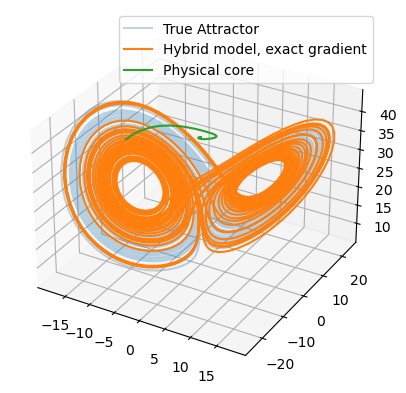

In [61]:
# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the line in 3D
ax.plot(dataset[:,0], dataset[:,1], dataset[:,2], label='True Attractor', alpha = 0.3)
ax.plot(simulation_hybrid.cpu().numpy()[:,0], simulation_hybrid.cpu().numpy()[:,1], simulation_hybrid.cpu().numpy()[:,2], label='Hybrid model, exact gradient')
ax.plot(simulation_init_sys.cpu().numpy()[:,0], simulation_init_sys.cpu().numpy()[:,1], simulation_init_sys.cpu().numpy()[:,2], label='Physical core')
plt.legend()